# Analysis of the single assessment


In [169]:
import os
import pickle
import numpy as np
import pandas as pd   # module to work with data in DataFrames.
import seaborn as sns  # module to plot DataFrames in an easy way
import matplotlib.pyplot as plt
from pathlib import Path
import scipy.constants as sc
import scipy.stats as stats

Seaborn setup.

In [170]:
# seaborn comes with default presets (called 'contents') for figure's aesthetics, 
# such as the font size, figure size etc.

sns.set_context('paper') # try: 'talk', 'poster', 'notebook'
sns.set_theme(style="ticks", palette="pastel")

# Set global color scheme for historic and modern images.
sns_palette_historic = ["m"]
sns_palette_modern = ["g"]

# Plot size and y limits.
sns_plot_size = (8*sc.golden_ratio, 8)
sns_half_plot_size = (4*sc.golden_ratio, 8)
sns_ylim = (-0.4, 1)

color_blue = '#4E92FF'

def set_hline(plot):
    plot.axhline(0.0, color=color_blue, linewidth=2.0, label="No manipulation")

## Get the result files

In [171]:
# Get current result files.
result_dir = Path('../nines/results').absolute()
result_file_names = os.listdir(result_dir)
result_file_names = list(filter(lambda name: str.startswith(name, 'result'), result_file_names))

single_result_files_paths = []
for name in result_file_names:
    single_result_files_paths.append(result_dir / name)

num_observers = len(single_result_files_paths)
print(f"Number observer: {num_observers}")

Number observer: 23


## Create dataframe
Basic setup of dataframe:

In [172]:
df = pd.DataFrame()
for index, path in enumerate(single_result_files_paths):
    df_tmp = pd.read_csv(path)
    df_tmp['observer'] = index
    df = pd.concat((df, df_tmp))

df.columns = ['test_image', '0', '1', '2', '3', '4', '5', '6', '7', '8', 'choosen', 'observer']


Add short ID of the image to the dataframe.

In [173]:
df['id'] = [s.split('_')[0] for s in df['test_image'].tolist()]

Sort the dataframe by id of the images.

In [174]:
df = df.sort_values(by='id', ascending=True, key=lambda col: [int(img[1:]) for img in col])

Add type of the image in new column. Historic or modern (H, I).

In [175]:
df['type'] = [s[0] for s in df['id'].tolist()]

Some observers may have seen more images than planned for.
These images are removed.

In [176]:
# Historic image ids:
list_of_used_images = [f"H{index}" for index in range(30)]
# Modern images ids:
list_of_used_images += [f"I{index:02d}" for index in [1, 3, 4, 6, 7, 8, 12, 13, 14, 15 ,16, 20, 21, 22, 23]]

assert len(list_of_used_images) == 30 + 15

df = df[df["id"].isin(list_of_used_images)]

assert len(df) == (30 + 15) * num_observers

### Normalise chroma values
* The chroma values are normalised to the range [0, 1].
* Subtract all values to locate algorithm result factor at 0.0 in plots.

In [177]:
df["normalise"] = [(entry[0] / entry[1]) - (1 / entry[1]) for entry in list(zip(df["choosen"].tolist(), df["8"].tolist()))]

## Sanity checks
We expect 30 historic and 15 modern images used during tests.
Each result file  from each observer shall be 30 + 15 images long.

In [178]:
# sanity checks: how many groups do you expect per categorical variable?
assert len(df['test_image'].unique()) == 30 + 15

# Check number of observers.
assert len(df['observer'].unique()) == len(result_file_names) == num_observers

# Check length of result from each observer.
for observer_id in df['observer'].unique():
    assert len(df[df['observer'] == observer_id]) == 30 + 15
    assert len(df[df['observer'] == observer_id]['test_image'].unique()) == 30 + 15

# Check number of historic and modern images.
assert len(df[df['type'] == "H"]) == 30 * num_observers
assert len(df[df['type'] == "I"]) == 15 * num_observers

## Export dataframe

In [179]:
with open("niner.pkl", mode="wb") as pkl_file:
    pickle.dump(df, pkl_file)

## Dataframe

In [180]:
df

,test_image,0,1,2,3,4,5,6,7,8,choosen,observer,id,type,normalise
18,H0_recolor.BMP,0.6,1.0,1.42,1.84,2.27,2.70,3.14,3.58,4.03,0.60,17,H0,H,-0.099256
18,H0_recolor.BMP,0.6,1.0,1.42,1.84,2.27,2.70,3.14,3.58,4.03,3.58,20,H0,H,0.640199
44,H0_recolor.BMP,0.6,1.0,1.42,1.84,2.27,2.70,3.14,3.58,4.03,3.14,21,H0,H,0.531017
33,H0_recolor.BMP,0.6,1.0,1.42,1.84,2.27,2.70,3.14,3.58,4.03,3.58,1,H0,H,0.640199
3,H0_recolor.BMP,0.6,1.0,1.42,1.84,2.27,2.70,3.14,3.58,4.03,0.60,6,H0,H,-0.099256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34,H29_recolor.BMP,0.6,1.0,1.36,1.72,2.06,2.39,2.72,3.03,3.34,1.36,14,H29,H,0.107784
0,H29_recolor.BMP,0.6,1.0,1.36,1.72,2.06,2.39,2.72,3.03,3.34,3.03,22,H29,H,0.607784
5,H29_recolor.BMP,0.6,1.0,1.36,1.72,2.06,2.39,2.72,3.03,3.34,3.03,3,H29,H,0.607784
1,H29_recolor.BMP,0.6,1.0,1.36,1.72,2.06,2.39,2.72,3.03,3.34,2.72,8,H29,H,0.514970


Max factor used throughout all images.

In [181]:
max_factor = np.ceil(max(df[[str(i) for i in range(9)]].max(axis=0)))


In [182]:
df[df["type"] == "H"]["normalise"]

18   -0.099256
18    0.640199
44    0.531017
33    0.640199
3    -0.099256
        ...   
34    0.107784
0     0.607784
5     0.607784
1     0.514970
5     0.514970
Name: normalise, Length: 690, dtype: float64

### Historic plots

Boxplot

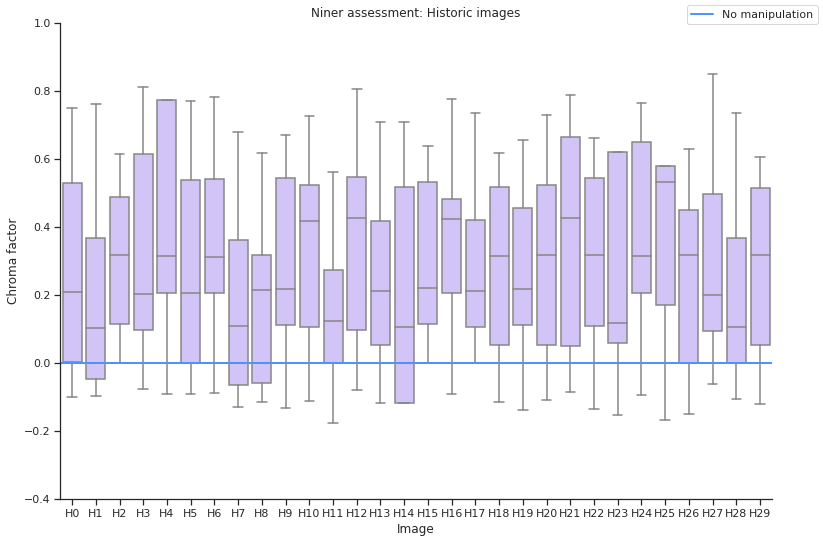

In [183]:
g = sns.catplot(
    x='id',
    y='normalise',
    data=df[df["type"] == "H"],
    kind='box',
    ci='sd',
    palette=sns_palette_historic
)
set_hline(g.axes[0][0])
g.fig.set_size_inches(sns_plot_size)
g.set(ylim = sns_ylim)

g.figure.legend()

g.set_axis_labels("Image", "Chroma factor")
g.set(title="Niner assessment: Historic images")

sns.despine()

g.savefig("niner_historic.png", dpi=400)

### Modern plots

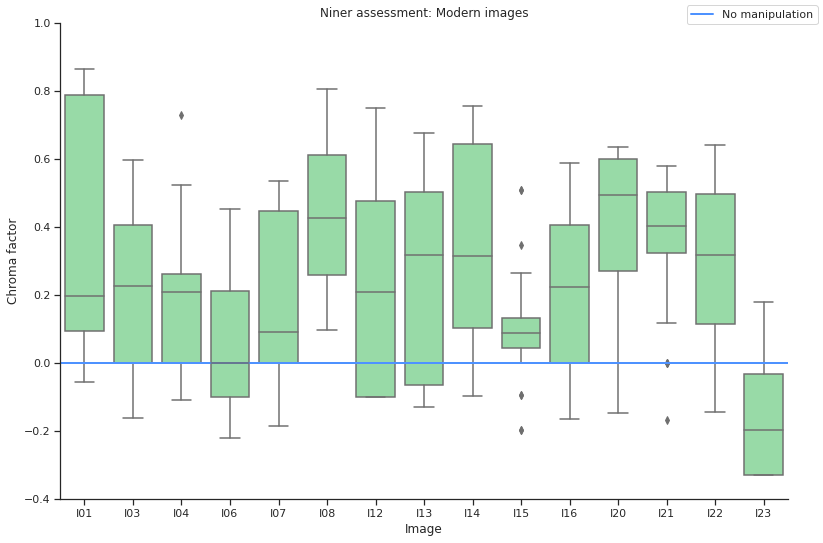

In [184]:
g = sns.catplot(
    x='id',
    y='normalise',
    data=df[df["type"] == "I"],
    kind='box',
    ci='sd', 
    palette=sns_palette_modern
)
set_hline(g.axes[0][0])

g.fig.set_size_inches(sns_plot_size)
g.figure.legend()
g.set(ylim = sns_ylim)

g.set_axis_labels("Image", "Chroma factor")
g.set(title="Niner assessment: Modern images")
sns.despine()
g.savefig("niner_modern.png", dpi=400)

# Plots for both image groups

Get mean of normalised choosen factor for each image. Stored in own dataframe.

In [185]:
means = []
for img in df[df["type"] == "H"]["id"].unique():
    means.append((img, "H", np.median(df[df["id"] == img]["normalise"])))

for img in df[df["type"] == "I"]["id"].unique():
    means.append((img, "I", np.median(df[df["id"] == img]["normalise"])))
    
df_mean = pd.DataFrame(means)
df_mean.columns = ["id", "type", "mean"]

# Check new dataframe with one image id.
assert np.isclose(np.median(df[df["id"] == "I01"]["normalise"]), df_mean[df_mean["id"] == "I01"]["mean"])

In [186]:
np.median(df[df["id"] == "I"]["choosen"])

/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:3256: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/lib/python3/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan

Boxplot overall modern and historic images.

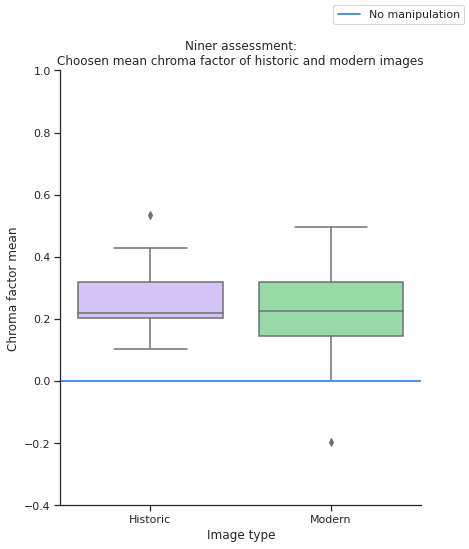

In [187]:
g = sns.boxplot(
    x="type",
    y="mean",
    palette=[sns_palette_historic[0], sns_palette_modern[0]],
    data=df_mean
)
set_hline(g)

g.set(title="Niner assessment:\nChoosen mean chroma factor of historic and modern images")
g.figure.set_size_inches(sns_half_plot_size)
g.set(ylim = sns_ylim)
g.set_xlabel("Image type")
g.set_ylabel("Chroma factor mean")
g.set(xticklabels=["Historic", "Modern"])
g.figure.legend()
sns.despine()
g.figure.savefig("niner_both.png", dpi=400)

## t-Test

Select data from all observers and for all images. Devided into the two groups.

In [188]:
historic = df[df["type"] == "H"]["normalise"]
modern = df[df["type"] == "I"]["normalise"]

assert len(historic) == 30 * num_observers
assert len(modern) == 15 * num_observers

Perform the t-test.
* Null hypothesis: 2 independent samples have identical average (expected) values.
* Our null hypothesis: The samples for historic and modern images have identical average values.

In [189]:
t_stat, p_value = stats.ttest_ind(historic, modern)

print('P-value:', p_value)
print(f"P-value << 0.05 and reject null hypothesis: {np.less(p_value, 0.05)}.")

P-value: 0.00990801585278501
P-value << 0.05 and reject null hypothesis: True.


Result: We reject the null hypothesis. We have to assume both groups do **not** have identical average expected values.

## Plots for single observer

In [190]:
df_observer = df[df["observer"] == 10]


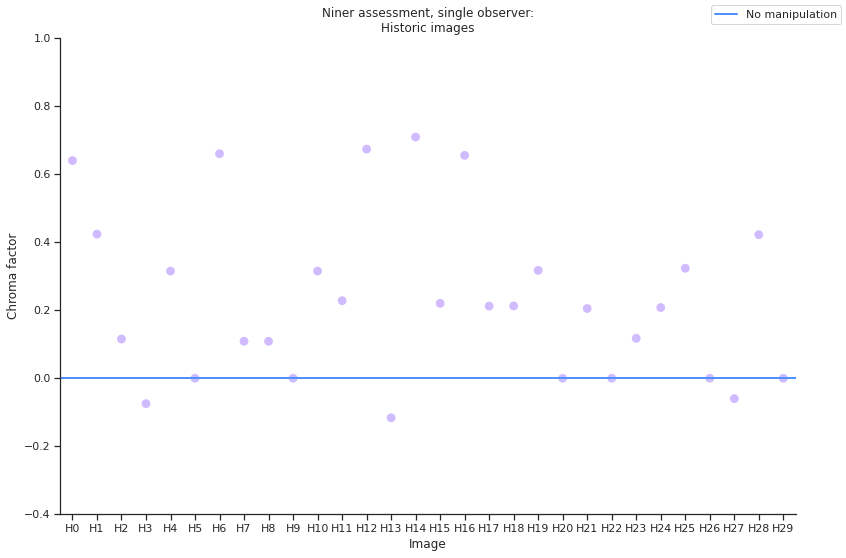

In [191]:
g = sns.catplot(
    x='id',
    y='normalise',
    data=df_observer[df_observer["type"] == "H"],
    kind='point',
    ci='sd',
    palette=sns_palette_historic
)
set_hline(g.axes[0][0])
g.fig.set_size_inches(sns_plot_size)
g.set(ylim = sns_ylim)

g.figure.legend()

g.set_axis_labels("Image", "Chroma factor")
g.set(title="Niner assessment, single observer:\nHistoric images")

sns.despine()

g.savefig("niner_observer_historic.png", dpi=400)